# Modeldrift with Eurybia
<b>With this tutorial you:</b><br />
Understand how to use Eurybia to detect model drift

Contents:
- Detect data drift  
- Display model drift over years

This tutorial contains only additional features of model drift.
For more detailed information on data drift, you can consult these tutorials :
(https://github.com/MAIF/eurybia/tree/master/tutorial/data_drift)

**Requirements notice** : the following tutorial may use third party modules not included in Eurybia.  
You can find them all in one file [on our Github repository](https://github.com/MAIF/eurybia/blob/master/requirements.dev.txt) or you can manually install those you are missing, if any.

In [11]:
import pandas as pd
import numpy as np
from datetime import date
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from eurybia import SmartDrift
from eurybia.data.data_loader import data_loading
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

## Import Dataset and split in training and production dataset

In [3]:
house_df, house_dict = data_loading('house_prices')

In [4]:
# Let us consider that the column "YrSold" corresponds to the reference date. 
#In 2006, a model was trained using data. And in 2007, we want to detect data drift on new data in production to predict
#house price
house_df_learning = house_df.loc[house_df['YrSold'] == 2006]
house_df_2007 = house_df.loc[house_df['YrSold'] == 2007]

In [5]:
y_df_learning=house_df_learning['SalePrice'].to_frame()
X_df_learning=house_df_learning[house_df_learning.columns.difference(['SalePrice','YrSold'])]

y_df_2007=house_df_2007['SalePrice'].to_frame()
X_df_2007=house_df_2007[house_df_2007.columns.difference(['SalePrice','YrSold'])]

## Building Supervized Model


In [6]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df_learning.columns if X_df_learning[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df_learning)

X_df_learning_encoded=encoder.transform(X_df_learning)

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df_learning_encoded, y_df_learning, train_size=0.75, random_state=1)

In [8]:
regressor = LGBMRegressor(n_estimators=200).fit(Xtrain,ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 53
[LightGBM] [Info] Start training from score 181743.472340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Use Eurybia for data drift

In [13]:
X_df_2007["MasVnrType"] = X_df_2007["MasVnrType"].fillna("NR")
X_df_learning["MasVnrType"] = X_df_learning["MasVnrType"].fillna("NR")
SD = SmartDrift(df_current=X_df_2007,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [14]:
%time 
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2007,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )
                 

CPU times: user 7 μs, sys: 1e+03 ns, total: 8 μs
Wall time: 9.78 μs
The variable BsmtCond has mismatching unique values:
['Poor -Severe cracking, settling, or wetness'] | []

The variable Condition2 has mismatching unique values:
['Near positive off-site feature--park, greenbelt, etc.', 'Adjacent to North-South Railroad', 'Adjacent to East-West Railroad'] | ['Adjacent to feeder street']

The variable Electrical has mismatching unique values:
['Mixed'] | ['60 AMP Fuse Box and mostly knob & tube wiring (poor)']

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
[] | ['Stone', 'Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
['Asphalt Shingles', 'Brick Common'] | ['Other']

The variable Foundation has mismatching unique values:
[] | ['Stone', 'Wood']

The variable Functional has mismatching unique values:
['Major Deductions 2', 'Severely Damaged'] | ['Moderate Deductions']

The variable 

As soon as compile() method, Eurybia displays default consistency checks as warnings.<br />
If some modalities are not present during training and are in production dataset, the deployed model will consider them wrongly.<br />
Inversely, if some modalities are present during training and are not in production dataset, it means that some profiles are missing.

## Add model drift in report

For the moment, the model drift part of eurybia only consists of displaying performance of deployed model. 
(We hope to bring new features in the future on this part)

### Put model performance in DataFrame

In [15]:
y_pred = regressor.predict(Xtest)

In [16]:
performance_test = mean_squared_log_error(ytest, y_pred).round(6)
performance_test

0.030775

In [17]:
#Create Dataframe to track performance over the years
df_performance = pd.DataFrame({'annee': [2006], 'mois':[1], 'performance': [performance_test]})

In [18]:
df_2007_encode=encoder.transform(X_df_2007)
y_pred_2007 = regressor.predict(df_2007_encode)
performance_2007 = mean_squared_log_error(y_df_2007, y_pred_2007).round(6)
performance_2007

0.032982

In [21]:
df_performance = pd.concat([df_performance, pd.DataFrame([{'annee': 2007, 'mois': 1, 'performance': performance_2007}])], ignore_index=True)
df_performance

,annee,mois,performance
0,2006,1,0.030775
1,2007,1,0.032982
2,2007,1,0.032982


### Add performance Dataframe in Smartdrift

In [22]:
SD.add_data_modeldrift(dataset=df_performance,metric='performance') 

In [23]:
SD.generate_report(    
    output_file='report_house_price_modeldrift_2007.html',    
    title_story="Data drift",
    title_description="""House price model drift 2007""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_house_price.yml" # Optional: add information on report
    )

Eurybia is designed to generate an HTML report for analysis, and less for use in notebook mode. 
However, to illustrate functionalities, we will detail results with notebook mode analysis.

This tutorial contains only anlysis on additional features of model drift. For more detailed information on data drift, you can consult these tutorials : (https://github.com/MAIF/eurybia/tree/master/tutorial/data_drift)

### Display model drift

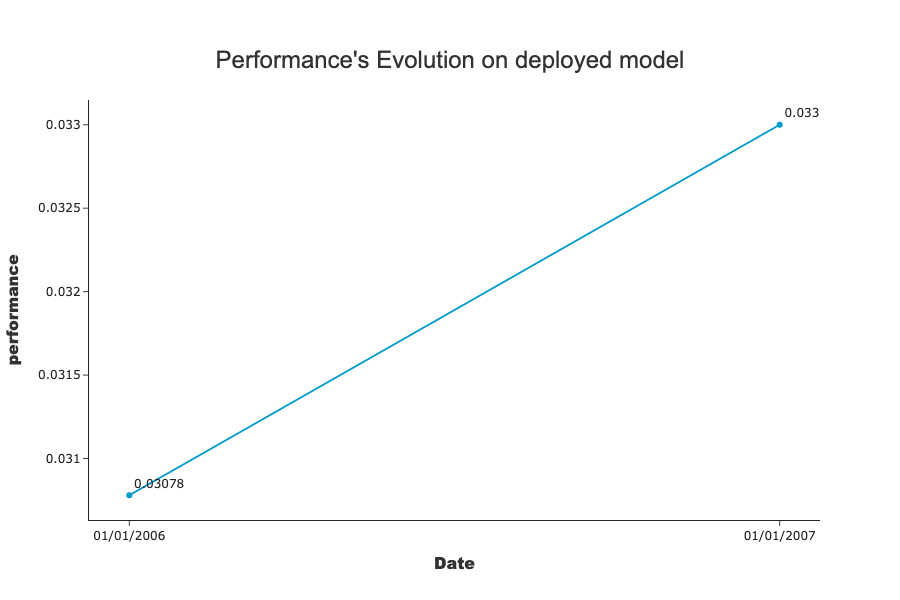

In [ ]:
SD.plot.generate_modeldrift_data() # works if date_compile_auc and/or datadrift_file are filled

### Display model drift with multiple indicators

If you have several metrics or indicators for performance monitoring, it is possible to have reference columns.
Let's create a dummy performance table to show the use.

In [25]:
df_performance_mse = df_performance.copy()
df_performance_mse['performance']= np.exp(df_performance_mse['performance'])
df_performance2 = pd.concat([df_performance, df_performance_mse], keys=["rmse", "mse"]).reset_index().rename(columns={"level_0": "indicator"})
df_performance2

,indicator,level_1,annee,mois,performance
0,rmse,0,2006,1,0.030775
1,rmse,1,2007,1,0.032982
2,rmse,2,2007,1,0.032982
3,mse,0,2006,1,1.031253
4,mse,1,2007,1,1.033532
5,mse,2,2007,1,1.033532


In [26]:
SD.add_data_modeldrift(dataset=df_performance2,metric='performance',reference_columns=['indicator']) 

In [27]:
SD.generate_report(    
    output_file='report_house_price_modeldrift_2007.html',    
    title_story="Data drift",
    title_description="""House price model drift 2007""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_house_price.yml" # Optional: add information on report  
    )

## Compile Drift over years

### Compile Drift et generate report for Year 2008

In [28]:
house_df_2008 = house_df.loc[house_df['YrSold'] == 2008]

y_df_2008=house_df_2008['SalePrice'].to_frame()
X_df_2008=house_df_2008[house_df_2008.columns.difference(['SalePrice','YrSold'])]

In [29]:
df_2008_encode=encoder.transform(X_df_2008)
y_pred_2008 = regressor.predict(df_2008_encode)
performance_2008 = mean_squared_log_error(y_df_2008, y_pred_2008).round(6)
performance_2008

0.027948

In [30]:
df_performance = pd.concat([df_performance, pd.DataFrame([{'annee': 2008, 'mois': 1, 'performance': performance_2008}])], ignore_index=True)
df_performance

,annee,mois,performance
0,2006,1,0.030775
1,2007,1,0.032982
2,2007,1,0.032982
3,2008,1,0.027948


In [34]:
X_df_2008["MasVnrType"] = X_df_2008["MasVnrType"].fillna("NR")
X_df_learning["MasVnrType"] = X_df_learning["MasVnrType"].fillna("NR")
SD = SmartDrift(df_current=X_df_2008,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [35]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2008,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | []

The variable Condition2 has mismatching unique values:
['Adjacent to arterial street', "Within 200' of North-South Railroad", 'Adjacent to postive off-site feature', 'Near positive off-site feature--park, greenbelt, etc.'] | []

The variable Electrical has mismatching unique values:
['Mixed'] | []

The variable ExterCond has mismatching unique values:
['Excellent'] | []

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
[] | ['Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
[] | ['Other', 'Stone']

The variable Foundation has mismatching unique values:
[] | ['Slab', 'Wood']

The variable Functional has mismatching unique values:
['Major Deductions 2'] | []

The variable GarageCond has mismatching unique values:
['Excellent'] | ['Poor']

The variable GarageQual has mismatching unique valu

In [36]:
SD.add_data_modeldrift(dataset=df_performance,metric='performance') 

In [37]:
SD.generate_report(    
    output_file='report_house_price_modeldrift_2008.html',    
    title_story="Model drift",
    title_description="""House price model drift 2008""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_house_price.yml" # Optional: add information on report
    )

### Compile Drift et generate report for Year 2009

In [38]:
house_df_2009 = house_df.loc[house_df['YrSold'] == 2009]

y_df_2009=house_df_2009['SalePrice'].to_frame()
X_df_2009=house_df_2009[house_df_2009.columns.difference(['SalePrice','YrSold'])]

In [39]:
df_2009_encode=encoder.transform(X_df_2009)
y_pred_2009 = regressor.predict(df_2009_encode)
performance_2009 = mean_squared_log_error(y_df_2009, y_pred_2009).round(6)
performance_2009

0.031738

In [40]:
X_df_2009["MasVnrType"] = X_df_2009["MasVnrType"].fillna("NR")
X_df_learning["MasVnrType"] = X_df_learning["MasVnrType"].fillna("NR")
SD = SmartDrift(df_current=X_df_2009,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [42]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2009,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable BsmtCond has mismatching unique values:
['Poor -Severe cracking, settling, or wetness'] | []

The variable Condition1 has mismatching unique values:
[] | ['Adjacent to East-West Railroad']

The variable Condition2 has mismatching unique values:
['Adjacent to arterial street'] | []

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly knob & tube wiring (poor)']

The variable ExterCond has mismatching unique values:
['Excellent'] | []

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
['Brick Common', 'Cinder Block'] | ['Stone', 'Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
['Brick Common', 'Cinder Block'] | ['Other']

The variable Functional has mismatching unique values:
['Major Deductions 2'] | []

The variable GarageCond has mismatching unique values:
['Excellent'] | ['Good']

The variable GarageQual has mismatching unique values:

In [43]:
df_performance = pd.concat([df_performance, pd.DataFrame([{'annee': 2009, 'mois': 1, 'performance': performance_2009}])], ignore_index=True)

In [44]:
SD.add_data_modeldrift(dataset=df_performance,metric='performance') 

In [45]:
SD.generate_report(    
    output_file='report_house_price_modeldrift_2009.html',    
    title_story="Model drift",
    title_description="""House price model drift 2009""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_house_price.yml" # Optional: add information on report  
    )

### Compile Drift et generate report for Year 2010

In [46]:
house_df_2010 = house_df.loc[house_df['YrSold'] == 2010]

y_df_2010=house_df_2010['SalePrice'].to_frame()
X_df_2010=house_df_2010[house_df_2010.columns.difference(['SalePrice','YrSold'])]

In [47]:
df_2010_encode=encoder.transform(X_df_2010)
y_pred_2010 = regressor.predict(df_2010_encode)
performance_2010 = mean_squared_log_error(y_df_2010, y_pred_2010).round(6)
performance_2010

0.023161

In [49]:
df_performance = pd.concat([df_performance, pd.DataFrame([{'annee': 2010, 'mois': 1, 'performance': performance_2010}])], ignore_index=True)

In [50]:
X_df_2010["MasVnrType"] = X_df_2010["MasVnrType"].fillna("NR")
X_df_learning["MasVnrType"] = X_df_learning["MasVnrType"].fillna("NR")
SD = SmartDrift(df_current=X_df_2010,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [51]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2010,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | []

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly knob & tube wiring (poor)']

The variable ExterCond has mismatching unique values:
['Poor'] | []

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
['Asphalt Shingles'] | ['Stone', 'Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
['Asphalt Shingles', 'Brick Common'] | ['Other', 'Stone']

The variable Functional has mismatching unique values:
[] | ['Major Deductions 1']

The variable GarageCond has mismatching unique values:
[] | ['Poor', 'Good']

The variable GarageQual has mismatching unique values:
[] | ['Good', 'Excellent', 'Poor']

The variable GarageType has mismatching unique values:
[] | ['More than one type of garage']

The variable Heating has mismatching unique values:
[] | ['Gas hot water 

In [52]:
SD.add_data_modeldrift(dataset=df_performance,metric='performance') 

In [53]:
SD.generate_report(    
    output_file='report_house_price_modeldrift_2010.html',    
    title_story="Model drift",
    title_description="""House price model drift 2010""",
    project_info_file="../../eurybia/data/project_info_house_price.yml"  
    )

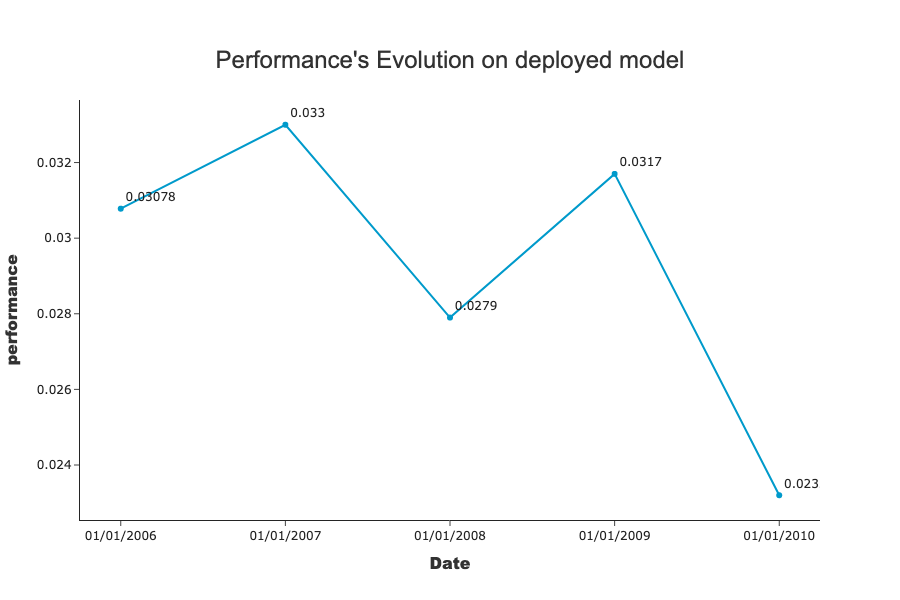

In [ ]:
SD.plot.generate_modeldrift_data() # works if add_data_modeldrift used before  

----